# <center>Simulating the Spread of Disease using ABM

<center> <b> &#9989; By William Chettleburgh, Jared Bloch, Cong Fu, Matei Gheorghiu

<img src="sickimg.jpg" style="width: 800px, height: 200px">
<center><font size="1">Source: Adobe Stock.</font>

## Introduction

Due to the spread of COVID-19, it has become increasingly important to determine methods of modelling the spread of disease, so that informed public policy decisions can be made. One well-known model (which was also explored in CMSE 201) is the **SIR model**, which uses a system of differential equations generated from a compartmental model to determine the changes in the number of **susceptible**, **<font color=red>infectious</font>**, or **<font color=green>recovered</font>** individuals over time.

<img src="diffeq.png" width="200" height="100">
<center><font size="2"> General system of ordinary differential equations of the SIR model
<center><font size="1">Source: Wikipedia compartmental models in epidemiology.</font>


However, the **SIR model** has several fundamental limitations. It assumes that the population is large enough so that all curves and rates can be considered to be continuous rather than discrete. For a disease that has very few infected people or is only present in a small population, this assumption can be false.

Additionally, the model assumes that the rates at any point in time are proportional to the number of infected or susceptible people at that same point in time, when in reality, there is typically a delay. For example, if at a particular time many people are infected, we would only expect to see a high recovery rate several days/weeks from then, since it takes time for a person to recover.

In this project, we attempt to code a model which does not rely on these assumptions. Specifically, we use an **agent based model (ABM)**, where each agent represents a single person. This allows disease transmission to be modelled discretely, so that only whole numbers of people move between groups. Likewise, individual agents can track variables pertaining to themselves, such as the length of time they have had the disease, how close they are to infected individuals, or how long they have been exposed. This allows the rules dictating disease transmission in the **ABM** to incorporate more variables (including the delays in the rates mentioned above).


### Goals of the project:

In this project we simulate how a general disease spreads using **ABM**. We then examine how changing the values of the parameters in the model affects the final result. We also test how other changes to the model (such as allowing people to recatch the disease or adding a probability of death) impact the course of the disease. Finally, we compare our results to those found using the **SIR model**.

__Specifically, the questions we aim to answer are:__

- How do the number of people who are **susceptible**, **<font color=red>infectious</font>**, or **<font color=green>recovered</font>** change over time?

- How does this compare to the results predicted by the **SIR model** (which uses differential equations)?

- How do the values of the parameters and the assumptions made affect the course of the disease?

- How does the model change if we allow agents to re-catch the disease 

- How does the model change if the agents have a chance of dying?




## Methodology

In our model, we use a similar structure to the **SIR model**, defining separate groups for **susceptible**, **<font color=red>infectious</font>**, or **<font color=green>recovered</font>** agents. **Susceptible** agents are able to catch the disease from **<font color=red>infectious</font>** agents, whereas **<font color=green>recovered</font>** agents are unable to catch the disease. The agents move randomly on a grid, causing them to interact with each other. For the purposes of simplifying the movement, we turn the grid into a torus (i.e., when an agent leaves one side, they reenter on the other side).

To determine how likely it is for an agent to catch the disease, we define an attribute called exposure. The higher a susceptible agent’s exposure at any point in time, the higher the probability that the agent catches the disease at that point in time. The exposure of a susceptible agent increases when they are in the vicinity of an infected individual. Specifically, the amount by which their exposure increases is dictated by two variables: how long the infected individual has been infected, and how close the two agents are.


Depending on how long the infected individual has been infected, their infectivity changes. For many diseases, the infectivity follows a normal distribution that is skewed to the right. Specifically, infectivity is low when they first become infected, quickly increases to a maximum, and then slowly decreases until they recover. We define a function to represent this called the infectivity function, which takes the time since the agent first caught the disease as the input and returns the amount of exposure that they “give” to nearby susceptible agents. For our disease in particular, on average the maximum is at 25 time units (with an exposure of 45). This then trails off until it reaches a near-zero exposure at 70 time units.

<table><tr>
<td> <img src="Infectivity.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="Infectivity2.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>
<center><font size="2"> Our left model is our coded infectivity function, and the right model are multiple plots of our function with random parameters. Source (1)


However, an agent that is far away from the infected person should receive less exposure than an agent which is closer. To reflect this, we define a distance function, which takes the distance between the two agents as input and returns the proportion of the above exposure that the agent actually receives. This function follows a generalized logistic curve (so it takes values between 0 and 1). When the agents are close, the proportion is near 1. When the agents are further away, the proportion is closer to 0.

<img src="Distance.PNG" alt="Drawing" style="width: 500px;"/> </td>
<center><font size="2"> This is based on a Type I generalized logistic distribution from source (2)

In summary, the amount of exposure a susceptible agent receives is the value of the infectivity function times the value of the distance function. Now, given a current level of exposure, the probability that the agent catches the disease must be determined. Since this should take values between 0 and 1, we again use a logistic curve. The inflection point (or the exposure value at which the probability is 50%) is one of the parameters we vary in our model. For higher values of this parameter, more exposure is needed to catch the disease. For lower values, less exposure is needed.


<table><tr>
<td> <img src="Exposure.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="Exposure2.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>
<center><font size="2"> Our left model is our coded exposure function, and the right model are multiple plots of our function with random parameters.


We assume that an agent recovers once their infectivity (as given by the infectivity function) falls below 1. In order to add additional randomness and realism to our model, we use random values for many of the parameters in the above functions, so that the functions differ slightly on a person-by-person basis. This helps to reflect real-world factors such as being immunocompromised.

### Code from above:

In [47]:
import numpy as np # Used for storing locations and calculating distances

import matplotlib.pyplot as plt # Used for making scatterplots and line plots
from matplotlib.gridspec import GridSpec # Used for creating more customized subplots

import scipy.special # Used in the formula for a skewed normal distribution
from scipy.stats import truncnorm # Used for generated truncated normal distributions

from sympy import * # Used for symbolic mathematics (in developing the infectivity, distance, and exposure functions)
from sympy.utilities.lambdify import lambdify # Used for converting sympy functions to vectorized functions

from IPython.display import display, clear_output, Math # Used for creating the animation and displaying Latex
from ipywidgets.widgets import interact, FloatSlider # Used for making interactive plots

In [48]:
def get_var_dist(mean, sd, maxdev):
    '''Generate a slider and distribution reflecting a truncated normal distribution. This is used to create distributions
    for the parameters in the infectivity and exposure functions (each of which are randomized on a per person basis).
    
    Parameters
    ----------
    mean: float
        The mean of the distribution.
        
    sd: float
        The standard deviation of the distribution.
        
    maxdev: float
        The distance of the cutoff from the mean.
        
    Returns
    -------
    slider: FloatSlider
        A slider object for use in interactive plots, with bounds equal to the cutoffs of the distribution.
        
    dist: rv_frozen
        The distribution. Values from it can be generated by calling its rvs method (with the number of values as a
        parameter).
    '''
    
    minval = mean-maxdev # Calculate the minimum value of the distribution
    maxval = mean+maxdev # Calculate the maximum value of the distribution
    slider = FloatSlider(min=minval, max=maxval, step=(maxval-minval)/20, value=mean) # Create the slider
    dist = truncnorm(-maxdev/sd, maxdev/sd, loc=mean, scale=sd) # Create the distribution
    return slider, dist

# Infectivity Function

In [49]:
# Store and display the Latex function for the infectivity function
# Note that this can be copy and pasted into Desmos
# This is based on a skewed normal distribution from
# https://en.wikipedia.org/wiki/Skew_normal_distribution
infectivity_latex = r"$\frac{a}{s\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-m}{s}\right)^{2}}\left(1+\operatorname{erf}\left(\frac{k\left(\frac{x-m}{s}\right)}{\sqrt{2}}\right)\right)$"
display(Math(infectivity_latex))

# Define the symbols used in the equation
# a represents a scalar multiplier (the larger a is, the larger the infectivity at any point in time)
# m roughly is the center of the infectivity function (the time at which infectivity is highest)
# s represents the spread of the distribution
# k represents the skew of the distribution (higher values yield a larger skew)
# x is the independent variable (time)
a, m, s, k, x = symbols("a, m, s, k, x")
# Rewrite the infectivity function using Sympy
infectivity_form = a/(s*(2*pi)**.5) * exp(-1/2*((x-m)/s)**2) * (1+erf((k*(x-m)/s)/(2**.5)))
# Convert the function to a vectorized function
infectivity_func_raw = lambdify([x, a, m, s, k], infectivity_form, modules=['numpy', {'erf': scipy.special.erf}])

infectivity_sliders = {} # Define a dictionary to hold the sliders for each parameters
infectivity_dists = {} # Define a dictionary to hold the distributions for each parameter
infectivity_sliders["a"], infectivity_dists["a"] = get_var_dist(1100, 30, 100) # Store the slider/distribution for a
infectivity_sliders["m"], infectivity_dists["m"] = get_var_dist(20, 3, 10) # Store the slider/distribution for m
infectivity_sliders["s"], infectivity_dists["s"] = get_var_dist(17.5, 0.75, 2.5) # Store the slider/distribution for s
infectivity_sliders["k"], infectivity_dists["k"] = get_var_dist(5, 0.5, 2) # Store the slider/distribution for k

<IPython.core.display.Math object>

In [50]:
# Make an interactive plot to display simulated distributions for each of the parameters

@interact(variable = infectivity_sliders.keys())
def plot_dists(variable):
    '''Plot a simulated histogram of the distribution for an infectivity function parameter.
    
    Parameters
    ----------
    variable: str
        One of the keys in the infectivity_slider dictionary.
        
    Returns
    -------
    None
    '''
    
    plt.hist(infectivity_dists[variable].rvs(10000), bins=20)
    plt.title("Simulated Distribution of Infectivity Variables")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()

interactive(children=(Dropdown(description='variable', options=('a', 'm', 's', 'k'), value='a'), Output()), _d…

In [51]:
# Make an interactive plot to display the infectivity function for different values of the parameters

@interact(**infectivity_sliders)
def plot_infectivity_func(**kwargs):
    '''Plot the infectivity function.
    
    Parameters
    ----------
    a: float
        The multiplier for the infectivity function.
        
    m: float
        The center for the infectivity function (roughly).
        
    s: float
        The spread for the infectivity function.
        
    k: float
        The skew of the infectivity function (more skew for higher value).
        
    Returns
    -------
    None
    '''
    
    x_range = np.linspace(0,100,100) # Define the range of x-values for which to make the plot
    plt.plot(x_range, infectivity_func_raw(x_range, **kwargs)) # Calculate and plot the infectivity function
    plt.ylim(0,65)
    
    plt.title("Infectivity Function")
    plt.xlabel("Time Since First Infected")
    plt.ylabel("Infectivity")
    plt.grid()
    plt.show()

interactive(children=(FloatSlider(value=1100.0, description='a', max=1200.0, min=1000.0, step=10.0), FloatSlid…

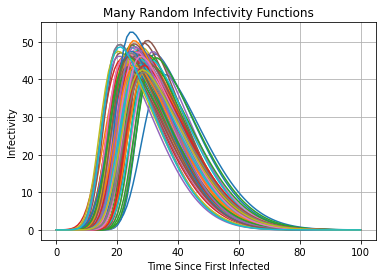

In [52]:
# Plot several infectivity functions with parameters pulled from their corresponding distributions

for i in range(100):
    a = infectivity_dists["a"].rvs() # Obtain a value for a
    m = infectivity_dists["m"].rvs() # Obtain a value for m
    s = infectivity_dists["s"].rvs() # Obtain a value for s
    k = infectivity_dists["k"].rvs() # Obtain a value for k
    
    x_range = np.linspace(0,100,100) # Define the range of x-values for which to make the plot
    plt.plot(x_range, infectivity_func_raw(x_range, a=a, m=m, s=s, k=k)) # Calculate and plot the infectivity function

plt.title("Many Random Infectivity Functions")
plt.xlabel("Time Since First Infected")
plt.ylabel("Infectivity")
plt.grid()
plt.show()

# Distance Function

<IPython.core.display.Math object>

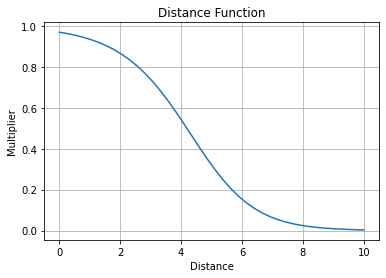

In [53]:
# Store and display the Latex function for the distance function
# Note that this can be copy and pasted into Desmos
# This is based on a Type I generalized logistic distribution from
#https://en.wikipedia.org/wiki/Generalized_logistic_distribution
distance_latex = r"$1-\left(Qe^{-x}+1\right)^{-v}$"
display(Math(distance_latex))

# Define the symbols used in the equation
# Q and v are both parameters which can be tuned to get the desired shape
# x is the independent variable (distance)
Q, v, x = symbols('Q, v, x')
# Rewrite the distance function using Sympy
distance_form = 1-(Q*exp(-x)+1)**(-v)
# Define the parameters for the distance function
distance_params = [(Q, 100), (v, 0.75)]
# Covert the function to vectorized function
distance_func = lambdify(x, distance_form.subs(distance_params), "numpy")

# Plot the distance function
x_range = np.linspace(0,10,40) # Define the range of x-values for which to make the plot
plt.plot(x_range, distance_func(x_range)) # Calculate and plot the distance function
plt.title("Distance Function")
plt.xlabel("Distance")
plt.ylabel("Multiplier")
plt.grid()
plt.show()

# Exposure Function

In [54]:
# Store and display the Latex function for the exposure function
# Note that this can be copy and pasted into Desmos
# This is a logistic distribution
exposure_latex = r"$\frac{1}{1 + e^{- k \left(x-s\right)}}$"
display(Math(exposure_latex))

# Define the symbols used in the equation
# k is the growth rate of the exposure function
# s is the inflection point of the exposure function (the exposure for which the function has the steepest increase)
# x is the independent variable (exposure)
k, s, x = symbols('k, s, x')
# Rewrite the exposure function using Sympy
exposure_form = 1/(1+exp(-k*(x-s)))
# Define one of the parameters for the exposure function
exposure_params = [(k, .068)]
# Convert the function to a vectorized function
exposure_func_raw = lambdify([x, s], exposure_form.subs(exposure_params)-.007, "numpy")

exposure_sliders = {} # Define a dictionary to hold the sliders for each parameters
exposure_dists = {} # Define a dictionary to hold the distributions for each parameter
exposure_sliders["s"], exposure_dists["s"] = get_var_dist(100, 6, 25) # Store the slider/distribution for s

<IPython.core.display.Math object>

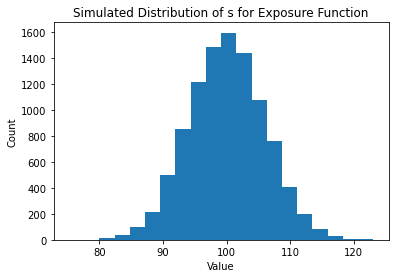

In [55]:
# Make an plot to display the simulated distribution for the parameter s in the exposure function

plt.hist(exposure_dists["s"].rvs(10000), bins=20)
plt.title("Simulated Distribution of s for Exposure Function")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [56]:
# Make an interactive plot to display the expsure function for different values of the parameter s

@interact(**exposure_sliders)
def plot_exposure_func(s=100):
    x_range = np.linspace(0,400,100)

    plt.plot(x_range, exposure_func_raw(x_range, s))
    plt.title("Exposure Function")
    plt.xlabel("Exposure Value")
    plt.ylabel("Probability of Catching Disease")
    plt.grid()
    plt.show()

interactive(children=(FloatSlider(value=100.0, description='s', max=125.0, min=75.0, step=2.5), Output()), _do…

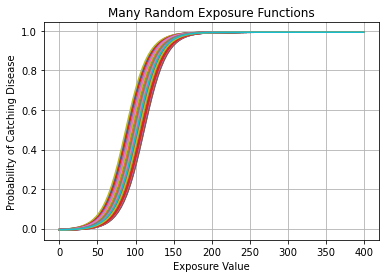

In [57]:
# Plot several exposure functions with parameters pulled from their corresponding distributions

for i in range(100):
    s = exposure_dists["s"].rvs()
    
    x_range = np.linspace(0,400,100)
    plt.plot(x_range, exposure_func_raw(x_range, s))

plt.title("Many Random Exposure Functions")
plt.xlabel("Exposure Value")
plt.ylabel("Probability of Catching Disease")
plt.grid()
plt.show()

In [58]:
def person_wrapper(func, params):
    '''Wrap one of the above functions so that it can be called with a person object (and then the parameters for
    that person are retrieved and used).
    
    Parameters
    ----------
    func: function
        The function to wrap.
    
    params:
        A string representing the name of the attribute containing the parameters. This attribute must be a dictionary 
        with the parameter names as keys and the parameter values as values.
        
    Returns
    -------
    output: function
        The wrapped function, accepting the x value as the first argument and the person object as the second.
    '''
    
    def inner(x, person):
        return func(x, **getattr(person, params))
    
    return inner

In [59]:
# Wrap the infectivity and exposure functions so that they can be called with a person object (rather than the values
# of the parameters themselves)
infectivity_func = person_wrapper(infectivity_func_raw, "infectivity_params")
exposure_func = person_wrapper(exposure_func_raw, "exposure_params")

# Classes

In [60]:
class Person:
    '''A class representing a person in the simulation. A person object contains information specific to each person,
    while the remainder of information in the agent based model is contained in the Environment class. No methods are
    defined in the Person class; rather, actions are carried out by the environment.
    
    Attributes
    ----------
    location: ndarray
        The 1D array of length 2 representing the location of the person. The first element is the x-coordinate, and
        the second element is the y-coordinate.
        
    speed: float
        The distance the person travels per unit time.
        
    infectivity_params: dict
        A dictionary containing the values for the parameters of the infectivity function. The keys are the 
        parameter names, and the values are the parameter values themselves.
        
    exposure_params: dict
        A dictionary containing the values for the parameters of the exposure function. The keys are the 
        parameter names, and the values are the parameter values themselves.
        
    angle: float
        The angle at which the person is currently travelling, in radians.
        
    angle_deviation: float
        The maximum angle by which the person's direction changes per unit time, in radians.
        
    exposure: float
        The amount of exposure the person has had to the disease.
        
    caught_time: int (or None)
        The time at which the person last caught the disease. If they have not caught the disease before, then the value 
        is None.
        
    recovered_time: int (or None)
        The time at which the person last recovered from the disease. If they have not recovered from the disease before,
        then the value is None.
    '''
    
    def __init__(self, 
                 location, 
                 speed, 
                 infectivity_params, 
                 exposure_params):
        '''Initialize a person object. See the docstring for Person for more information.
        
        Parameters
        ----------
        location: ndarray
            The 1D array of length 2 representing the location of the person. The first element should be the 
            x-coordinate, and the second element should be the y-coordinate.

        speed: float
            The distance the person travels per unit time.

        infectivity_params: dict
            A dictionary containing the values for the parameters of the infectivity function. The keys should be
            the parameter names, and the values should be the parameter values themselves.

        exposure_params: dict
            A dictionary containing the values for the parameters of the exposure function. The keys should be the 
            parameter names, and the values should be the parameter values themselves.
        '''
        
        args = locals().copy() # Extract a copy of all local variables as a dictionary (i.e., the function arguments)
        del args["self"] # Remove self from the dictionary
        self.__dict__.update(args) # Add all of these arguments as attributes of the object
        
        self.angle = np.random.uniform(0, 2*np.pi) # Initialize a random angle in which the person is moving
        self.angle_deviation = .5 # Initialize the angle deviation to 0.5
        
        self.exposure = 0 # Initialize the exposure to 0 (the minimum value)
        self.caught_time = None # Initialize the time when the person last caught the disease to None
        self.recovered_time = None # Initialize the time when the person last recovered from the disease to None
        
class Environment:
    '''The Envionment class holds parameters that affect all people equally, as well as the methods for running and
    advancing the agent based model.
    
    Attributes
    ----------
    infectivity_func: function
        The infectivity function (taking time since caught and a person object as arguments and returning the base
        amount of exposure to contribute to neighboring susceptible agents).
        
    distance_func: function
        The distance function (taking distance as an argument and returning the proportion of the exposure that the
        person actually receives).
        
    exposure_func: function
        The exposure function (taking level of exposure and a person object as arguments and returning the probability
        that the person catches the disease in that moment of time).
        
    infectivity_dists: dict
        The distributions of the infectivity function parameters. The keys should be strings representing the name
        of the paramter, and the values should be distributions of the type rv_frozen.
        
    exposure_dists: dict
        The distributions of the exposure function parameters. The keys should be strings representing the name of
        the parameter, and the values should be distributions of the type rv_frozen.
        
    radius: float
        The radius within transmission is possible.
        
    shape: ndarray
        The dimensions of the environment as a 1D array of length two. The first element is the width and the second
        is the height.
        
    speed: float
        The speed of the people in the simulation.
        
    immunity_time: int
        The length of time a person is immune from the disease after recovering.
        
    exposure_decrement: float
        The amount by which a person's exposure decreases each unit time.
        
    permanent_immunity: bool
        If True, agents are permanently immune after recovering from the disease. If False, agents can recatch the
        disease multiple times.
        
    is_death: bool
        If True, infected agents have a chance of dying. If False, no death is incorporated into the model.
        
    death_prob: float
        The probability that an infected agent dies at any point in time.
        
    people: dict
        A dictionary containing the agents. The keys are the group the agents are in, which is either "S" for
        susceptible, "I" for infected, "R" for recovered, or "D" for dead. The values are lists of Person
        objects.
        
    time: int
        The current time in the simulation (increases by 1 each step).
        
    Methods
    -------
    add_person: Adds a person to the simulation.
    
    advance_time: Advance the simulation by one step in time, and obtain arrays of the locations of each person.
    '''
    
    def __init__(self, 
                 infectivity_func=infectivity_func, 
                 distance_func=distance_func, 
                 exposure_func=exposure_func, 
                 infectivity_dists=infectivity_dists,
                 exposure_dists=exposure_dists,
                 radius=8, 
                 shape=np.array([100,100]), 
                 speed=1, 
                 immunity_time=60, 
                 exposure_decrement=15, 
                 permanent_immunity=True,
                 is_death=False,
                 death_prob=0.0002):
        
        '''Initialize an Environment object. See the docstring for Environment for more information.

        Parameters
        ----------
        infectivity_func: function
            The infectivity function (taking time since caught and a person object as arguments and returning the base
            amount of exposure to contribute to neighboring susceptible agents). Defaults to the previously-defined
            infectivity function.

        distance_func: function
            The distance function (taking distance as an argument and returning the proportion of the exposure that the
            person actually receives). Defaults to the previously-defined distance function.

        exposure_func: function
            The exposure function (taking level of exposure and a person object as arguments and returning the probability
            that the person catches the disease in that moment of time). Defaults to the previously-defined exposure 
            function.

        infectivity_dists: dict
            The distributions of the infectivity function parameters. The keys should be strings representing the name
            of the paramter, and the values should be distributions of the type rv_frozen. Defaults to the previously-
            defined distributions for the infectivity parameters.

        exposure_dists: dict
            The distributions of the exposure function parameters. The keys should be strings representing the name of
            the parameter, and the values should be distributions of the type rv_frozen. Defulats to the previously-
            defined distributions for the exposure parameters.

        radius: float
            The radius within transmission is possible. Defaults to 8.

        shape: ndarray
            The dimensions of the environment as a 1D array of length two. The first element is the width and the second
            is the height. Defaults to a width and height of 100.

        speed: float
            The speed of the people in the simulation. Defaults to 1.

        immunity_time: int
            The length of time a person is immune from the disease after recovering. Defaults to 60.

        exposure_decrement: float
            The amount by which a person's exposure decreases each unit time. Defaults to 15.

        permanent_immunity: bool
            If True, agents are permanently immune after recovering from the disease. If False, agents can recatch the
            disease multiple times. Defaults to True.

        is_death: bool
            If True, infected agents have a chance of dying. If False, no death is incorporated into the model. Deaults
            to False.

        death_prob: float
            The probability that an infected agent dies at any point in time. Defaults to 0.0002.
        '''
        
        args = locals().copy() # Extract a copy of all local variables as a dictionary (i.e., the function arguments)
        del args["self"] # Remove self from the dictionary
        self.__dict__.update(args) # Add all of these arguments as attributes of the object
        
        self.people = {"S": [], "I": [], "R": [], "D": []} # Initialize a dictionary to house the agents by group
        self.time = 0 # Initiaze the time to 0
        
    def _gen_location(self):
        '''Generate a random location within the environment.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        output: ndarray
            A location as a 1D array of length 2, where the first element is the x-coordinate and the second element
            is the y-coordinate.
        '''
        
        return np.random.uniform(self.shape)
    
    def _gen_params(self):
        '''Generate random parameters for the infectivity and exposure functions.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        output: dict
            A dictionary, containing the keys "infectivity_params" and "exposure_params" and the values as dictionaries
            containing the parameter values (the keys are the parameter names and the values are the values of the
            parameters).
        '''
        
        # Initialize a dictionary of parameters for the infectivity function through dictionary comprehension
        infectivity_params = {key:dist.rvs() for key,dist in infectivity_dists.items()}
        # Initialize a dictionary of parameters for the exposure function through dictionary comprehension
        exposure_params = {key:dist.rvs() for key,dist in exposure_dists.items()}
        return {"infectivity_params": infectivity_params, "exposure_params": exposure_params}
        
    def add_person(self, group="S"):
        '''Add a person to the environment.
        
        Parameters
        ----------
        group: str
            The group to which the person is added. It should be one of "S" for susceptible, "I" for infected,
            "R" for recovered, or "D" for dead. Defaults to "S".
        
        Returns
        -------
        None
        '''
        
        # Initialize the person with a random location, the speed specified in the environment, and random 
        # parameters for the infectivity and exposure funtions
        person = Person(location = self._gen_location(), speed = self.speed, **self._gen_params())
        
        # Initialize caught_time and recovered_time to 0 if necessary
        if group=="I":
            person.caught_time = 0
        elif group=="R":
            person.recovered_time = 0
            
        self.people[group].append(person) # Append the person to the appropriate list.
            
    def _move_all(self):
        '''Move all agents in the simulation.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''

        for group in self.people.values(): # Loop over all groups of people
            for person in group: # Loop over the people within each group
                # Modify the angle by a random amount from a uniform distribution
                person.angle += np.random.uniform(-person.angle_deviation, person.angle_deviation)
                # Calculate the displacement vector of length given by their speed and direction given by their angle
                vector = person.speed*np.array([np.cos(person.angle), np.sin(person.angle)])
                # Update their location, causing them to wrap over edges if necessary
                person.location = np.mod(person.location+vector, self.shape)
    
    def _infected_actions(self):
        '''Perform all necessary actions on the infected population for a single time step. Specifically, infected
        people are either recovered or infect their neighbors. Then, if they are still infected, they may have
        a chance of dying.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        
        # Loop over the list of infected people by index in reverse (since the list may be modified)
        idx = len(self.people["I"])-1
        while idx >= 0:
            infected = self.people["I"][idx] # Access the person at the current index
            time_since_caught = self.time - infected.caught_time # Calculate the time the person has been infected
            infectivity = self.infectivity_func(time_since_caught, infected) # Calculate the infectivity of the person
            
             # If infectivity is low (and past the peak), then the person recovers
            if time_since_caught>40 and infectivity<1:
                del self.people["I"][idx] # Delete the person from the infected list
                self.people["R"].append(infected) # Add the person to the recovered list
                infected.recovered_time = self.time # Set the recovered time to the current time
            else:
                for person in self.people["S"]: # Loop over all susceptible agents
                    # Find the shortest vector connecting the two people (allowed to wrap over edges)
                    vector = np.abs(person.location - infected.location)
                    wrapped_vector = np.minimum(vector, self.shape-vector)
                    distance = np.linalg.norm(wrapped_vector, ord=2) # Calculate the distance between the two people
                    # If the distance is less than the radius, increase the exposure of the person
                    if distance <= self.radius:
                        person.exposure += infectivity*self.distance_func(distance)
            # If death is a factor in the model, use a random number to see if the person dies
            if self.is_death and np.random.random() < self.death_prob:
                del self.people["I"][idx] # Delete the person from the infected list
                self.people["D"].append(infected) # Add the perosn to the dead list
            idx -= 1 # Decrement the index
    
    def _susceptible_actions(self):
        '''Perform all necessary actions on the susceptible population for a single time step. Specifically, 
        susceptible either catch the disease or have their exposure decremented.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        
        # Loop over the list of susceptible people by index in reverse (since the list may be modified)
        idx = len(self.people["S"])-1
        while idx >= 0:
            susceptible = self.people["S"][idx] # Access the person at the current index
            # Check if the person catches the disease using the exposure function
            if np.random.random() < self.exposure_func(susceptible.exposure, susceptible):
                del self.people["S"][idx] # Delete the person from the susceptible list
                self.people["I"].append(susceptible) # Add the person to the infected list
                susceptible.caught_time = self.time
            else:
                # Decrement the exposure of the person (without going below 0)
                susceptible.exposure = max(susceptible.exposure-self.exposure_decrement, 0)
            idx -= 1 # Decrement the index
            
    def _recovered_actions(self):
        '''Perform all necessary actions on the recovered population for a single time step. Specifically, 
        recovered people may be moved back to susceptible if their immunity period is over (and permanent_immunity
        is False).
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        
        # Only run the following code if it is possible to catch the disease again
        if not self.permanent_immunity:
            # Loop over the list of recovered people by index in reverse (since the list may be modified)
            idx = len(self.people["R"])-1
            while idx>= 0:
                recovered = self.people["R"][idx] # Access the person at the current index
                # Check if the immunity for the recovered person has ended
                if self.time > recovered.recovered_time+self.immunity_time:
                    del self.people["R"][idx] # Delete the person from the recovered list
                    self.people["S"].append(recovered) # Add the person to the susceptible list
                    recovered.exposure = 0 # Reset the exposure to 0
                idx -= 1 # Decrement the index
                
    def _get_location_arrays(self):
        '''Get arrays representing the location of the people in each group, excluding the dead.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        output: list
            A list of arrays of locations of the people, where the first element is the susceptible population, 
            the second is the infected population, and the third is the recovered population. Each array has 
            two columns, where the first column is the x-coordinates of the people and the second column is the 
            y-coordinates.
        '''
        
        return [np.array([person.location for person in group]) for group_name, group in self.people.items() if group_name != "D"]
    
    def advance_time(self):
        '''Advance the time of the simulation.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        output: list
            A list of arrays of locations of the people, where the first element is the susceptible population, 
            the second is the infected population, and the third is the recovered population. Each array has 
            two columns, where the first column is the x-coordinates of the people and the second column is the 
            y-coordinates.
        '''
        self.time += 1 # Increment the time
        self._move_all() # Move all agents
        
        self._infected_actions() # Perform infected actions
        self._susceptible_actions() # Perform susceptible actions
        self._recovered_actions() # Perform recovered actions
    
        return self._get_location_arrays()

In [61]:
np.random.seed(31415) # Set a random seed for reproducability

# Initialize the environment
env = Environment(permanent_immunity=False, exposure_decrement=15, is_death=True)

# Add susceptible agents
for _ in range(299):
    env.add_person()
    
# Add an infected agent
env.add_person("I")

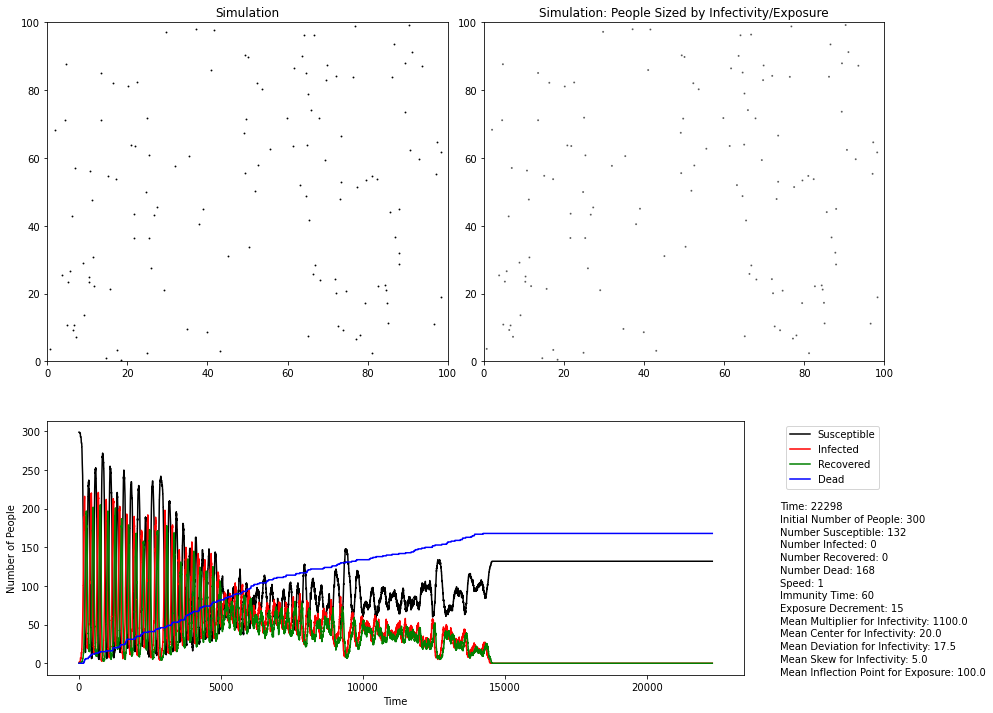

In [ ]:
fig = plt.figure(figsize=(15,12)) # Initialize a figure
gs = GridSpec(2,4, figure=fig, height_ratios=[4,3], width_ratios=[5,2,5,2]) # Specify the subplots with GridSpec
ax_sim1 = fig.add_subplot(gs[0,:2]) # Initialize the main simulation pane
# Set the limits on the main simulation pane
ax_sim1.set_xlim(0,env.shape[0])
ax_sim1.set_ylim(0,env.shape[1])

ax_sim2 = fig.add_subplot(gs[0,2:]) # Initialize the secondary simulation pane
# Set the limits on the secondary simulation pane
ax_sim2.set_xlim(0,env.shape[0])
ax_sim2.set_ylim(0,env.shape[1])

ax_infected = fig.add_subplot(gs[1,:-1]) # Initialize a set of axes for a line graph of the size of the groups
ax_info = fig.add_subplot(gs[1,-1]) # Initialize a set of axes for textual information

# Initialize lists to hold the number of people in each group at each moment in time
num_s = []
num_i = []
num_r = []
num_d = []

while True: # Create an infinite loop, which can be ended with the stop button in Jupyter
    S_locs, I_locs, R_locs = env.advance_time() # Advance the time and store the locations of each group
    # Fix the dimensions of the arrays in the case that a group is empty
    if not S_locs.size:
        S_locs = np.empty(shape=(0,2))
    if not I_locs.size:
        I_locs = np.empty(shape=(0,2))
    if not R_locs.size:
        R_locs = np.empty(shape=(0,2))
    
    S_plot1 = ax_sim1.scatter(*S_locs.T, c="k", marker=".", s=3) # Plot the suseptible population in black
    R_plot1 = ax_sim1.scatter(*R_locs.T, c="g", marker=".", s=100) # Plot the recovered population in green
    I_plot1 = ax_sim1.scatter(*I_locs.T, marker=".", s=100, c="r") # Plot the infected population in red

    ax_sim1.set_title("Simulation") # Set the title of the main simulation pane
    
    # Initialize a list representing the sizing for each infected person (based on their infectivity)
    I_size = np.array([env.infectivity_func(env.time - person.caught_time, person) for person in env.people["I"]])+1
    # Initialize a list representing the sizing for each susceptible person (based on their exposure)
    S_size = np.array([person.exposure for person in env.people["S"]])+2
    S_plot2 = ax_sim2.scatter(*S_locs.T, c="k", marker=".", s=S_size*2, alpha=.5) # Plot the susceptible population
    R_plot2 = ax_sim2.scatter(*R_locs.T, c="g", marker=".", s=100, alpha=.5) # Plot the recovered population
    I_plot2 = ax_sim2.scatter(*I_locs.T, marker=".", s=I_size*20, c="r", alpha=.5) # Plot the infected population
    
    ax_sim2.set_title("Simulation: People Sized by Infectivity/Exposure") # Set the title of the secondary simulation pane
    
    # Update the lists with the current size of each group
    num_s.append(len(env.people["S"]))
    num_i.append(len(env.people["I"]))
    num_r.append(len(env.people["R"]))
    num_d.append(len(env.people["D"]))
    
    ax_infected.plot(num_s, color="k", label="Susceptible") # Plot the number of susceptible people over time
    ax_infected.plot(num_i, color="r", label="Infected") # Plot the number of infected people over time
    ax_infected.plot(num_r, color="g", label="Recovered") # Plot the number of recovered people over time
    if env.is_death:
        ax_infected.plot(num_d, color="b", label="Dead") # Plot the number of dead people over time

    ax_infected.set_xlabel("Time") # Set the x-label of the line graph
    ax_infected.set_ylabel("Number of People") # Set the y-label of the line graph
    
    ax_info.legend(*ax_infected.get_legend_handles_labels()) # Add a legend (in a different subplot, hence the argument)
    ax_info.axis('off') # Remove the axes from the text subplot

    if env.is_death: # Display text in the case that death is part of the model
        ax_info.text(0,.65,"Time: "+str(env.time),size=10)
        ax_info.text(0,.6,"Initial Number of People: "+str(num_s[-1]+num_i[-1]+num_r[-1]+num_d[-1]),size=10)
        ax_info.text(0,.55,"Number Susceptible: "+str(num_s[-1]),size=10)
        ax_info.text(0,.5,"Number Infected: "+str(num_i[-1]),size=10)
        ax_info.text(0,.45,"Number Recovered: "+str(num_r[-1]),size=10)
        ax_info.text(0,.4,"Number Dead: "+str(num_d[-1]),size=10)
        ax_info.text(0,.35,"Speed: "+str(env.speed),size=10)
        ax_info.text(0,.3,"Immunity Time: "+("inf" if env.permanent_immunity else str(env.immunity_time)),size=10)
        ax_info.text(0,.25,"Exposure Decrement: "+str(env.exposure_decrement),size=10)
        ax_info.text(0,.2,"Mean Multiplier for Infectivity: "+str(env.infectivity_dists["a"].mean()),size=10)
        ax_info.text(0,.15,"Mean Center for Infectivity: "+str(env.infectivity_dists["m"].mean()),size=10)
        ax_info.text(0,.1,"Mean Deviation for Infectivity: "+str(env.infectivity_dists["s"].mean()),size=10)
        ax_info.text(0,.05,"Mean Skew for Infectivity: "+str(env.infectivity_dists["k"].mean()),size=10)
        ax_info.text(0,.0,"Mean Inflection Point for Exposure: "+str(env.exposure_dists["s"].mean()),size=10)
    else: # Display text in the case that death is not part of the model
        ax_info.text(0,.7,"Time: "+str(env.time),size=10)
        ax_info.text(0,.65,"Total People: "+str(num_s[-1]+num_i[-1]+num_r[-1]),size=10)
        ax_info.text(0,.6,"Number Susceptible: "+str(num_s[-1]),size=10)
        ax_info.text(0,.55,"Number Infected: "+str(num_i[-1]),size=10)
        ax_info.text(0,.5,"Number Recovered: "+str(num_r[-1]),size=10)
        ax_info.text(0,.45,"Speed: "+str(env.speed),size=10)
        ax_info.text(0,.4,"Immunity Time: "+("inf" if env.permanent_immunity else str(env.immunity_time)),size=10)
        ax_info.text(0,.35,"Exposure Decrement: "+str(env.exposure_decrement),size=10)
        ax_info.text(0,.3,"Mean Multiplier for Infectivity: "+str(env.infectivity_dists["a"].mean()),size=10)
        ax_info.text(0,.25,"Mean Center for Infectivity: "+str(env.infectivity_dists["m"].mean()),size=10)
        ax_info.text(0,.2,"Mean Deviation for Infectivity: "+str(env.infectivity_dists["s"].mean()),size=10)
        ax_info.text(0,.15,"Mean Skew for Infectivity: "+str(env.infectivity_dists["k"].mean()),size=10)
        ax_info.text(0,.1,"Mean Inflection Point for Exposure: "+str(env.exposure_dists["s"].mean()),size=10)

    clear_output(wait=True) # Clear the output
    display(fig) # Display the model
    #plt.savefig("output/output"+str(env.time)) # Save the plot to the folder "output"
    I_plot1.remove() # Remove infected agents from the main simulation
    S_plot1.remove() # Remove susceptible agents from the main simulation
    R_plot1.remove() # Remove recovered agents from the main simulation
    I_plot2.remove() # Remove infected agents from the secondary simulation
    S_plot2.remove() # Remove susceptible agents from the secondary simulation
    R_plot2.remove() # Remove recovered agents from the secondary simulation
    ax_infected.cla() # Clear the line plot
    ax_info.cla() # Clear the info text

In [ ]:
# Sources
#https://en.wikipedia.org/wiki/Skew_normal_distribution
#https://en.wikipedia.org/wiki/Generalized_logistic_distribution
#https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
# https://stackoverflow.com/questions/1408818/getting-the-keyword-arguments-actually-passed-to-a-python-method
# https://stackoverflow.com/questions/8187082/how-can-you-set-class-attributes-from-variable-arguments-kwargs-in-python